In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
sns.set()

**Ben Rosenberg (bar94), Zach Katz (zdk4)**: Due to the fact that we will be partners on the term project, and following Prof. Udell's permission given in Office Hours last week, we created everything in Q1 together.

# Question 1a
This dataset is from MyAnimeList.net (Kaggle: https://www.kaggle.com/azathoth42/myanimelist), a database somewhat like iMDB which allows people to record the anime (i.e., predominantly Japanese animated TV shows and movies) that they've watched. In our visualizations we used a CSV of user data, which includes names, gender, birth dates, join dates, locations, and more. 

# Question 1b
Our question is as follows:
"Are there relationships between demographics and anime viewing patterns?"

# Question 1c

## Viz 1: distributions of watch time by gender
In this visualization, we attempt to analyze the total number of days watched with respect to gender. We use a violin plot to demonstrate the differences in spread in watchtime by gender.

In [29]:
#import the user data
users = pd.read_csv("users_cleaned.csv")

Because there are some outliers with insanely high view time that will distort how our plots look, we will
remove all watch time beyond the 99%th percentile.

In [41]:
quant_99 = np.quantile(users.user_days_spent_watching, 0.99)
users_adj = users[users.user_days_spent_watching < quant_99]

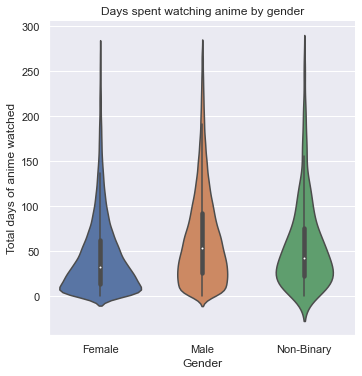

In [42]:
fg = sns.catplot(x="gender", y="user_days_spent_watching", data=users_adj, kind="violin", 
            jitter=False, dodge=True)
fg.set_axis_labels("Gender", "Total days of anime watched")
plt.title("Days spent watching anime by gender")
plt.show()


This plot reveals that, among the three gender options:

1. The spreads of watchtime are similar,
2. Males tend to watch the most anime, and
3. The distributions have very long tails on the top, despite efforts to remove significant outliers in making the distribution nicer.

*Note: Yes, these are actually days, not hours.*

# Viz 2: gender signups by year
In this visualization, we first created a new column (year that each user account was created), and sought to visualize the creation of new user accounts by year, and then by gender.

In [5]:
#create a year column based on the join_date column already in the dataset
users['join_year'] = users.join_date.apply(lambda x : pd.Timestamp(x).year)

In [6]:
#we will drop data from 2018 since the dataset was created in mid-2018, so 
#it would not accurately reflect all new signups that year
users_no_18 = users[users.join_year!=2018]

In [7]:
#count the number of unique users each year
#make into a nice df format
yearly_users = users_no_18.groupby(['join_year', 'gender'])['username'].count()

#the unstack() method allows us to split up our data by gender each year so it's easy for seaborn to plot
yearly_users = pd.DataFrame(yearly_users)

#rename to make plot look better
yearly_users.index.names = ["join_year", "Gender"]

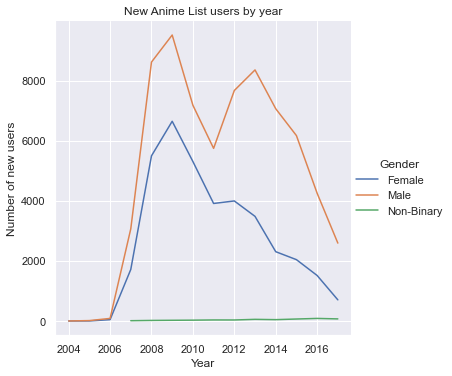

In [8]:
fg = sns.relplot(x="join_year", y='username', data=yearly_users, kind="line", hue='Gender')
fg.set_axis_labels("Year", "Number of new users")
plt.title("New Anime List users by year")
plt.show()


From this visualization we can see that across the board, there are more signups by males than by females, although both seem to trend down over time due to what might be considered the "carrying capacity" of anime-watchers. It's also interesting to note that in 2014, the males have a spike but the females don't, although outside of that the two trend together.

The nonbinary user base seems to be increasing and slightly tapering off towards the end (around 2018), likely due mostly to people feeling more comfortable in self-identifying as nonbinary.

# Viz 3 : KDE of age vs avg rating
In this visualization we wanted to look at the relationship between users' ages and how they rated anime on average. Using the joint plot allowed us to also get a look at the individual distributions of both age and rating.

In [9]:
###back to all of the users data (incl 2018 since we aren't plotting by year here)
##now we want to convert the birth_date to timestamps
users.birth_date = users.birth_date.apply(lambda x : pd.Timestamp(x))

In [10]:
#get users' ages
#thanks to the guide on https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
today = pd.Timestamp(date.today())
users['age'] = users.birth_date.apply(lambda birth : (today - birth) / timedelta(days = 365.24))

In [11]:
#we will delete users who have a mean score of 0. 
#this means they gave everything a 0, likely implying they didn't 
#actually rate it (probably data errors)
users_rating_cleaned = users[users.stats_mean_score!=0]

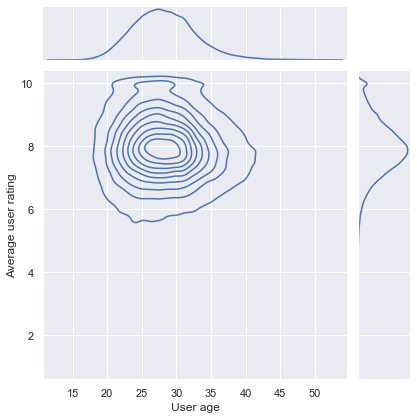

In [158]:
jp = sns.jointplot(x = "age", y = "stats_mean_score", data=users_rating_cleaned, kind="kde")
jp.set_axis_labels("User age (years)", "Average user rating")



From this visualization we can see that users tend to rate anime around the same level (generally around an 8, except around the top of the joint plot. The top seems to have a little of a breakaway in the contours, indicating a preference for rating anime a 10. This type of rating seems to only be a trend among younger people; over the age of 35, ratings seem to be more consistently normal.

# Viz 4: anime users by state
In this visualization, we wanted to get an idea of how MyAnimeList users were distributed across the United States. To that end, we had to sanitize the `location` field in the csv, which required some substantial string manipulation (as can be seen below). In order to normalize the populations of states, we used census estimates of state populations from 2018 (which was when this dataset was created) to compute per-capita user proportions. 

In [12]:
users.location

0                Chennai, India 
1               Detroit,Michigan
2                Nayarit, Mexico
3              Malaysia, Kuantan
4            Nijmegen, Nederland
                   ...          
108706                   Poland:
108707    nhollywood, california
108708                   Belgium
108709              Latvia, Riga
108710       Birmingham, England
Name: location, Length: 108711, dtype: object

In [13]:
states_ab = pd.Series(["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])
states_ab = states_ab.map(lambda x : x.upper())

#thanks : https://gist.github.com/JeffPaine/3083347

states = pd.Series(["Alaska", "Alabama", "Arkansas", "Arizona", "California", 
                    "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", 
 "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", 
                    "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", 
                    "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", 
                    "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
                     "Rhode Island", "South Carolina", "South Dakota", "Tennessee", 
                    "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", 
                    "West Virginia", "Wyoming"])
states = states.map(lambda x : x.upper())
#thanks: https://gist.github.com/norcal82/e4c7e8113f377db184bb

In [14]:
us_users = users.copy()

#get rid of periods in possible state abbreviations
us_users['location'] = us_users.location.map(lambda x : str(x).replace(".", "").upper())
#get rid of city names, also strip spaces
us_users.location = us_users.location.map(lambda x : str(x).split(",")[1].strip() if len(str(x).split(",")) > 1  else x.strip())

In [15]:
##we want per capita data, else we'll just have a map that looks like population
##first, we need to convert all the locations into one format: we want to use the state abbreviations

#thanks to https://gist.github.com/rogerallen/1583593, we have a premade dictionary

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",

}


#get lowercase keys to match current df
us_state_to_abbrev =  {k.upper(): v for k, v in us_state_to_abbrev.items()}
#thanks: https://stackoverflow.com/questions/30732915/convert-all-keys-of-a-dictionary-into-lowercase/30732980


#map to abbreviations
us_users.location = us_users.location.map(lambda x : us_state_to_abbrev[x] if x in us_state_to_abbrev else x)

In [16]:
###import census data
#source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_500989927
##users in the table are accurate as of mid-2018, so we'll use 2018 census data

census = pd.read_csv("census_data.csv")
#for some reason all states start with ., let's remove that and any potential blank space
#also make uppercase so it works with our dict
census.state = census.state.map(lambda x : str(x).replace(".", "").strip().upper())
##map states to abbreviations
census.state = census.state.map(lambda x : us_state_to_abbrev[x])

In [17]:
#isolate us users
us_users = us_users[(us_users.location.isin(states)) | (us_users.location.isin(states_ab)) ].copy()

#groupby to get count of users by state
tableau_data = pd.DataFrame(us_users.groupby('location')['user_id'].count())

#put the population data into the tableau_data df
tableau_data["state_pop"] = np.nan

#loop through each state and put the appropriate population into our tableau_data df
for state in states_ab:
    #use more string operations since the census puts commas in its numbers
    tableau_data.loc[tableau_data.index == state, ['state_pop']] = int(census[census.state == state]['2018'].values[0].replace(",",""))

#get per capita user data
tableau_data['users_per_cap'] = tableau_data.user_id / tableau_data.state_pop
    
tableau_data.to_csv("anime_locations.csv")



In [43]:
###view the tableau plot
from IPython.display import Image

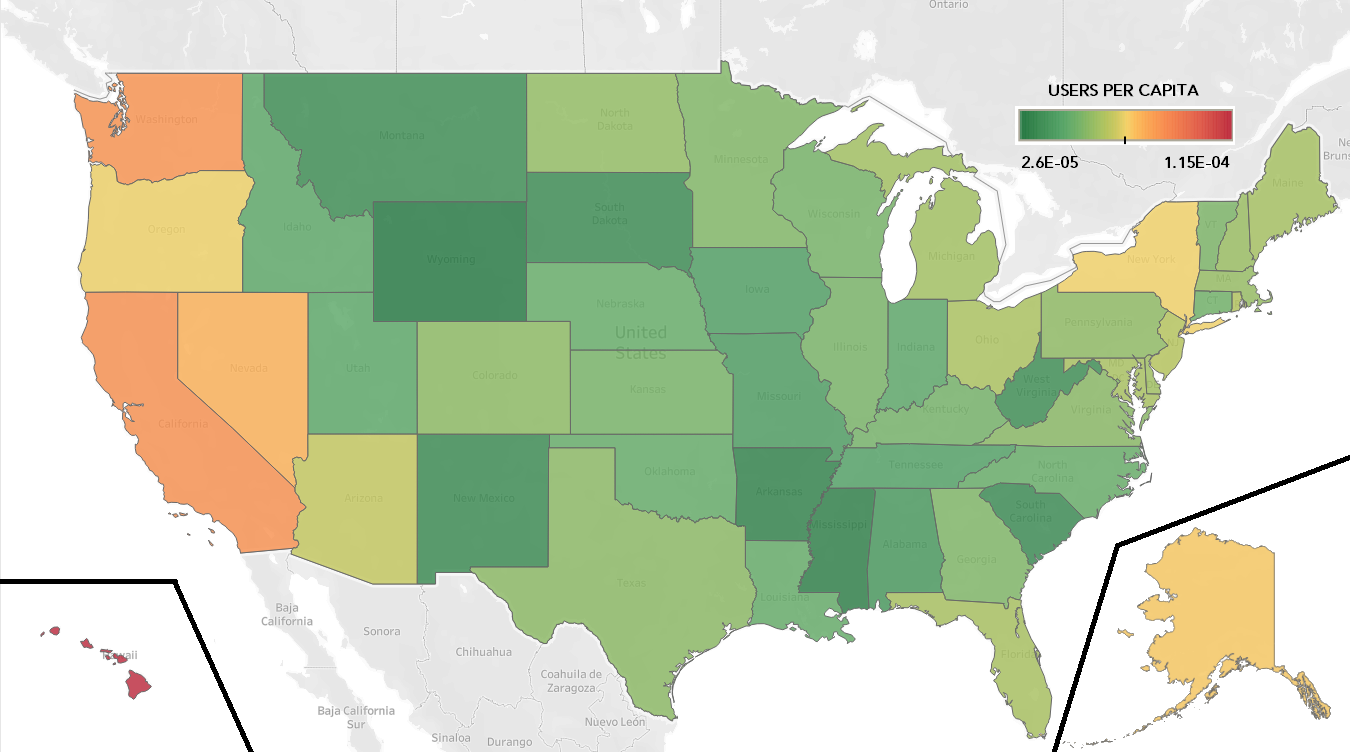

In [44]:
Image(filename = "anime_locations.png")

This map shows the number of MyAnimeList users per capita in each state. Notice that green corresponds to fewer users. The west coast states (as well as Alaska and Hawaii) have more users, potentially due to their relative proximity to Japan and the increased influence of Japanese culture that this creates. New York is an outlier on the east coast, likely due to similar cultural influence as a hub for immigration from around the world.